## Import libraries, load pkl file, standardized functions

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.interpolate
import time
from scipy.signal import savgol_filter
import copy

In [2]:
superhist = "histdataset1.pkl"
with open(superhist, "rb") as f:
    ds = pkl.load(f)

keys = ds.keys()
print(keys)

#in making the superhistogram, I only saved the data between 26500 and 103000 (see makehist line 237) 
#making the first bin 26500 as the left edge 

countarr = ds["C10"] #strictly the compiled im_arr of all the images 
mbins = np.arange(26500, 26500+len(countarr)) #built into the dataset 

#choose to start the data at 30k, but since the cubic spline interpolation does a poor job outside datapoints 
#the first datapoint would be at 30,000.5, and would cause issue in 30k-30,000.5

start = np.argwhere(mbins == 29999) 

termcountarr = countarr[start[0][0]:] #this starts histogram at 29,999
termbins = mbins[start[0][0]:] #this is the adc codes which this is valid for

dict_keys(['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'C01', 'C00'])


In [3]:
def examineinl(edges, binsnum, edgemethodname): #here binsnum is binnumbers 
    idealmids = 0.5 + binsnum
    adcmids = [sum(i) for i in zip(edges[1:], edges[:-1])] #add together elements
    adcmids[:] = [x / 2 for x in adcmids] #find their mean, verified 3 entires, sufficient
    arraymids = np.array(adcmids)*(-1) 
    inl = [sum(i) for i in zip(idealmids, arraymids)]
    plt.plot(binsnum, inl, color='black', label='inl')
    plt.title(f'{edgemethodname} inl by bin number')
    plt.xlabel("bin number")
    plt.ylabel("inl")
    plt.legend()
    plt.grid()
    return inl 

In [4]:
smoothed = savgol_filter(termcountarr, 33, 3)
cumulsum = np.cumsum(smoothed)

Text(0.5, 1.0, 'cumulative sum vs bin number')

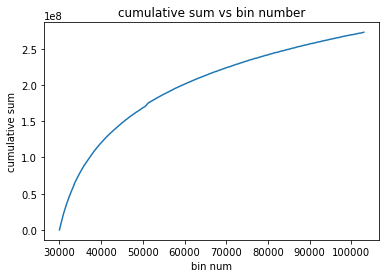

In [5]:
plt.plot(termbins, cumulsum)
plt.xlabel("bin num")
plt.ylabel("cumulative sum")
plt.title("cumulative sum vs bin number")

fit the cumulative sum to a spline

In [6]:
#take the bin values to be at the center of the bin
cs = scipy.interpolate.CubicSpline(termbins +0.5, cumulsum) #spline fitting for the cumulative values 
csx = np.arange(29999, 29999+len(termbins), 0.1)

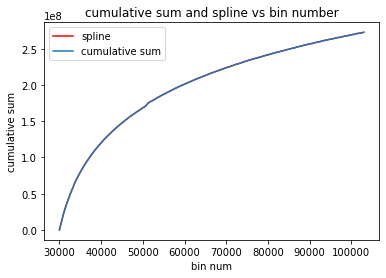

In [7]:
plt.plot(csx, cs(csx), color='red', label="spline")
plt.plot(termbins, cumulsum, label='cumulative sum')
plt.xlabel("bin num")
plt.ylabel("cumulative sum")
plt.title("cumulative sum and spline vs bin number")
plt.legend()

test whether the spline and the sums match 

the spline and the smoothed align, but filter (smoothed) still underestimates the input histogram (which is reasonable because there has been no change in how this handled. 

In [8]:
smoothedsum = cumulsum[-1] #the last element is the total 
countsum = sum(termcountarr) #add all elements together 

print("there is a mismatch")
print("smoothed sum - counts", smoothedsum - countsum)
print("")

splineend = cs(termbins[-1]+0.5) #the spline last value is needed 
print("mismatch spline and smoothed")
print("spline - counts", splineend - countsum)
print("")
print("by definition the spline and the smoothed match, which is good they do")
print("")
print("the filter still underestimates the counts")

there is a mismatch
smoothed sum - counts -986.2974393963814

mismatch spline and smoothed
spline - counts -986.2974393367767

by definition the spline and the smoothed match, which is good they do

the filter still underestimates the counts


(0.0, 3000.0)

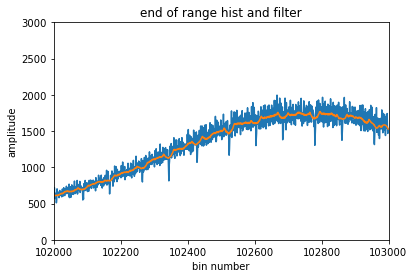

In [9]:
plt.plot(termbins, termcountarr, label='hist')
plt.plot(termbins, smoothed, label='filter')
plt.title("end of range hist and filter")
plt.xlabel("bin number")
plt.ylabel("amplitude")
plt.xlim(102000, 103000)
plt.ylim(0, 3000)

In [10]:
print(termcountarr[-1])
print(smoothed[-1])
print("the issue is not in indexing")
#this is an open question, I suppose we could improve the filter 

1524
1528.957049486461
the issue is not in indexing


In [11]:
print("the range of data is")
print(termbins[0]+0.5, termbins[-1]+0.5)

the range of data is
29999.5 102999.5


In [12]:
def makenarrow(bcvar, right, left):
    width = right - left
    width *= (1-bcvar) #reduce the width of the bin 
    right = width + left 
    bcvar *= 0.85 #make the change amount reduced by 85% 
    return right, bcvar
    
def makewide(bcvar, right, left): #function increases the bin width 
    width = right - left
    width *= (1+bcvar) #increase the width of the bin 
    right = width + left 
    bcvar *= 0.85 
    return right, bcvar

def makeedges(counts, spline):
    edges = [30000]
    for a in range(len(counts)):
        left = edges[-1]
        if left > 102999.5: #prevent interpolation beyond what we have for bins
            break
        Fr = counts[a] + spline(left) #F(r)= cs(right),

        right = left + 1 #standard bin width = 1
        cv = spline(right) #current value, based on current right edge
        
        bcvar = 0.25 #bin change variable (start with 25% change)  
        
        while len(edges) != a+2: 
            if Fr-0.01 < cv < Fr +0.01: #specify the requirement
                edges.append(right)
            
            elif cv < Fr: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                cv = spline(right)
            
            elif cv > Fr:  #bin is too big, reduce right edge
                right, bcvar = makenarrow(bcvar, right, left)
                cv = spline(right)
    return edges


In [13]:
start = time.time()
edges = makeedges(termcountarr[1:], cs) #exclude 29999 to start the array at 30k
end = time.time()
print("the runtime is:", end - start)

the runtime is: 22.624288082122803


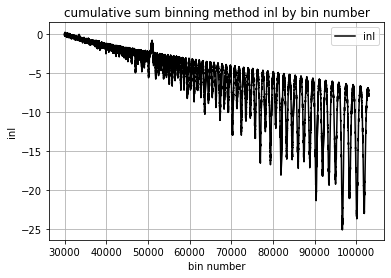

In [14]:
inlbins = 30000 + np.arange(0, len(edges)-1)
inl = examineinl(edges, inlbins, "cumulative sum binning method")

## I wonder if the bins are consistently too big or too small 


In [15]:
def makeedgesinvestigate(counts, spline):
    edges = [30000]
    bs = []
    for a in range(len(counts)):
        left = edges[-1]
        if left > 102999.5: #prevent interpolation beyond what we have for bins
            break
        Fr = counts[a] + spline(left) #F(r)= cs(right),

        right = left + 1 #standard bin width = 1
        cv = spline(right) #current value, based on current right edge
        
        bcvar = 0.25 #bin change variable (start with 25% change)  
        
        while len(edges) != a+2: 
            if Fr-0.01 < cv < Fr +0.01: #specify the requirement
                edges.append(right)
                if cv > Fr: #the bin made is wider than necessary 
                    bs.append(-1)
                elif cv < Fr: #the bin made is not wide enough
                    bs.append(1)
            elif cv < Fr: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                cv = spline(right)
            
            elif cv > Fr:  #bin is too big, reduce right edge
                right, bcvar = makenarrow(bcvar, right, left)
                cv = spline(right)
    return edges, bs

In [16]:
start = time.time()
edges, bs = makeedgesinvestigate(termcountarr[1:], cs) #exclude 29999 to start the array at 30k
end = time.time()
print("the runtime is:", end - start)

the runtime is: 22.717241048812866


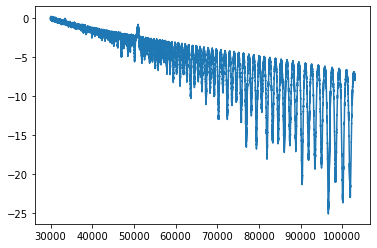

In [17]:
#plt.plot(np.arange(30000, 30000+len(edges)),edges)
#plt.plot(np.arange(30000, 30000+len(edges)), np.arange(30000, 30000+len(edges)))
plt.plot(np.arange(30000, 30000+len(edges)), np.arange(30000, 30000+len(edges))-edges)

+1 bin small, -1 bin wide


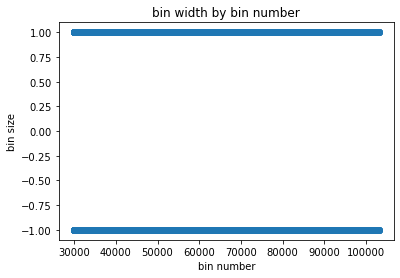

In [18]:
plt.scatter(np.arange(30000, 30000+len(bs)), bs)
plt.title("bin width by bin number")
plt.xlabel("bin number")
plt.ylabel("bin size")
print("+1 bin small, -1 bin wide")

Text(0.5, 1.0, 'bin distribution of wide/narrow')

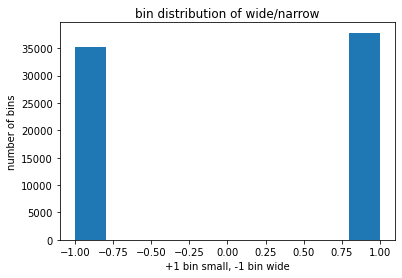

In [19]:
plt.hist(bs)
plt.xlabel("+1 bin small, -1 bin wide")
plt.ylabel("number of bins")
plt.title("bin distribution of wide/narrow")

more bins are not wide enough than too wide. So more bins need to be wider. This means on average the method underestimates the width of the bin. Which aligns with the fact the filter underestimates the values over the entire region. 

## Check that if the filter overestimated the values if then the bins overestimate the edges

In [20]:
smoothed2 = savgol_filter(termcountarr, 33, 3)
smoothed2 *= 1.00002 #factor selected for the magnitude of difference from the hist sum
cumulsum2 = np.cumsum(smoothed2)

In [21]:
smoothedsum2 = cumulsum2[-1] #the last element is the total 
countsum = sum(termcountarr) #add all elements together 
print("there is a mismatch")
print("smoothed sum - counts", smoothedsum2 - countsum)
print("")
print("the filter overestimates the hist")

there is a mismatch
smoothed sum - counts 4471.376213788986

the filter overestimates the hist


In [22]:
csbig = scipy.interpolate.CubicSpline(termbins +0.5, cumulsum2) #spline fitting for the cumulative values 

In [23]:
edgesbig, bsbig = makeedgesinvestigate(termcountarr[1:], csbig) #exclude 29999 to start the array at 30k

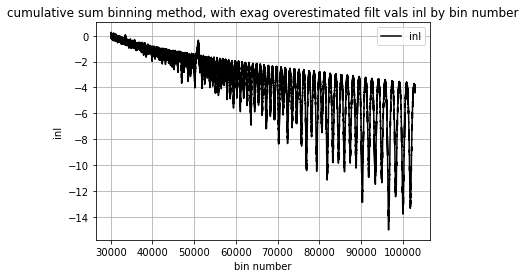

In [24]:
inlbinsbig = 30000 + np.arange(0, len(edgesbig)-1)
inlbig = examineinl(edgesbig, inlbinsbig, "cumulative sum binning method, with exag overestimated filt vals")

Text(0.5, 1.0, 'bin distribution of wide/narrow')

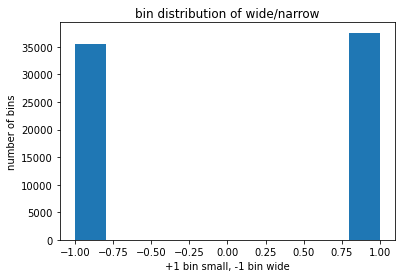

In [25]:
plt.hist(bsbig)
plt.xlabel("+1 bin small, -1 bin wide")
plt.ylabel("number of bins")
plt.title("bin distribution of wide/narrow")

the filter is not the issue in the underestimation of the bin edges, it is the method itself that causes the bins to be too small, and also have the inl be too large

## Such adding a correction to the filter doesn't kill the structure, oscillations, or inl

In [26]:
corr = sum(termcountarr)/sum(smoothed)
smoothed2 = copy.deepcopy(smoothed)
smoothed2 *= corr
cumulsum2 = np.cumsum(smoothed2)

#take the bin values to be at the center of the bin
cs2 = scipy.interpolate.CubicSpline(termbins +0.5, cumulsum2) #spline fitting for the cumulative values 

In [27]:
print(cumulsum2[-1])
print(sum(termcountarr))

272884668.9999999
272884669


In [28]:
start6 = time.time()
edges6 = makeedges(termcountarr[1:], cs2) #exclude 29999 to start the array at 30k
end6 = time.time()
print("the runtime is:", end6 - start6)

the runtime is: 22.614251613616943


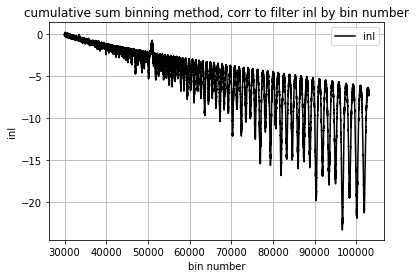

In [29]:
inlbins6 = 30000 + np.arange(0, len(edges6)-1)
inl6 = examineinl(edges6, inlbins6, "cumulative sum binning method, corr to filter")

## Does the inl improve when you decrease the convergence requirement

In [30]:
#convergence +/- 1, instead of 0.01

def makeedges4(counts, spline):
    edges = [30000]
    for a in range(len(counts)):
        left = edges[-1]
        if left > 102999.5: #prevent interpolation beyond what we have for bins
            break
        Fr = counts[a] + spline(left) #F(r)= cs(right),

        right = left + 1 #standard bin width = 1
        cv = spline(right) #current value, based on current right edge
        
        bcvar = 0.25 #bin change variable (start with 25% change)  
        
        while len(edges) != a+2: 
            if Fr- 1 < cv < Fr + 1: #specify the requirement
                edges.append(right)
            
            elif cv < Fr: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                cv = spline(right)
            
            elif cv > Fr:  #bin is too big, reduce right edge
                right, bcvar = makenarrow(bcvar, right, left)
                cv = spline(right)
    return edges

In [31]:
start4 = time.time()
edges4 = makeedges4(termcountarr[1:], cs)
end4 = time.time()
print("the runtime is:", end4 - start4)

the runtime is: 11.40281891822815


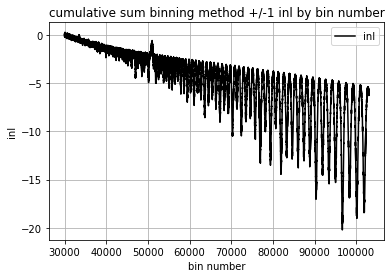

In [32]:
inlbins4 = 30000 + np.arange(0, len(edges4)-1)
inl4 = examineinl(edges4, inlbins4, "cumulative sum binning method +/-1")

In [33]:
#convergence +/- 5 

def makeedges5(counts, spline):
    edges = [30000]
    for a in range(len(counts)):
        left = edges[-1]
        if left > 102999.5: #prevent interpolation beyond what we have for bins
            break
        Fr = counts[a] + spline(left) #F(r)= cs(right),

        right = left + 1 #standard bin width = 1
        cv = spline(right) #current value, based on current right edge
        
        bcvar = 0.25 #bin change variable (start with 25% change)  
        
        while len(edges) != a+2: 
            if Fr- 5 < cv < Fr + 5: #specify the requirement
                edges.append(right)
            
            elif cv < Fr: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                cv = spline(right)
            
            elif cv > Fr:  #bin is too big, reduce right edge
                right, bcvar = makenarrow(bcvar, right, left)
                cv = spline(right)
    return edges

In [34]:
start5 = time.time()
edges5 = makeedges4(termcountarr[1:], cs)
end5 = time.time()
print("the runtime is:", end5 - start5)

the runtime is: 11.387605905532837


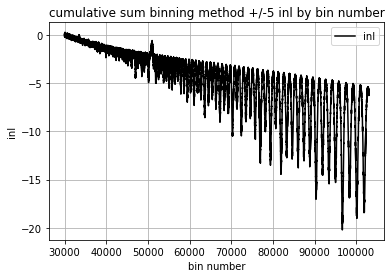

In [35]:
inlbins5 = 30000 + np.arange(0, len(edges5)-1)
inl5 = examineinl(edges5, inlbins5, "cumulative sum binning method +/-5")

While it does improve to some amount, the structure and oscillations are still present. 

## What about the residuals from past bins 

I wonder if there is some issue with the residual from the past bin, which is then forgotten about to introduce the inl. Try correcting by adding accounting for the difference in the next bin. 

In [36]:
def makeedges2(counts, spline):
    edges = [30000]
    for a in range(len(counts)):
        left = edges[-1]
        if left > 129999: #prevent interpolation beyond what we have for values
            break      
        
        Fr = counts[a] + spline(left) #this is the goal 
        right = left + 1 #generically start with width = 1 
        cv = spline(right) 

        bcvar = 0.25 #bin change variable (start with 25% change)        
        while len(edges) != a+2: 
            
            if Fr -0.01 < cv < Fr +0.01: #make the requirement sufficient
                edges.append(right)
                
                #account for the over/under estimation in the next bin ?
                if a+1 == len(counts):
                    break
                diff = cv - Fr
                counts[a+1] -= diff
                
                if cv > Fr: #the bin made is wider than necessary 
                    bs.append(-1)
                elif cv < Fr: #the bin made is not wide enough
                    bs.append(1)
            elif cv < Fr: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                cv = spline(right)
                
            elif cv > Fr:  #bin is too big, reduce right edge
                right, bcvar = makenarrow(bcvar, right, left)
                cv = spline(right)            
    return edges


In [37]:
start2 = time.time()
termcountarr2 = copy.deepcopy(termcountarr) #do not alter termcountarr
edges2 = makeedges2(termcountarr2[1:], cs)
end2 = time.time()
print("the runtime is:", end2 - start2)

the runtime is: 23.247719287872314


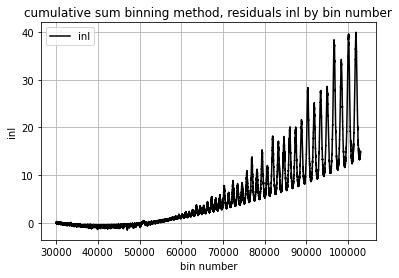

In [38]:
inlbins2 = 30000 + np.arange(0, len(edges2)-1)
inl2 = examineinl(edges2, inlbins2, "cumulative sum binning method, residuals")

(-2.0, 2.0)

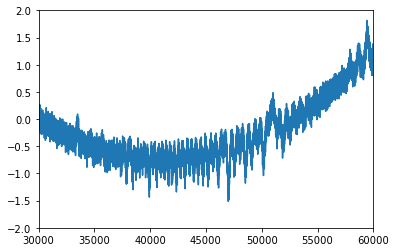

In [39]:
plt.plot(inlbins2, inl2)
plt.xlim(30000, 60000)
plt.ylim(-2, 2)

seems to do okay for the first 20k codes, and then takes off with the oscillatory manner. I will likely revisit this idea.

## Investigate the tracking of the inl and the slope of the hist imput 
that is, do the wide bins occur when we have an increasing slope or something else, or are they not related? 

In [40]:
#remember that bs is a list of 1/-1 
#-1 meant the bin was too wide, +1 bin too narrow

st = []
for x in range(len(termcountarr) -1):
    if termcountarr[x] < termcountarr[x+1]: #the slope is positive 
        st.append(1)
    elif termcountarr[x] > termcountarr[x+1]: #the slope is negative 
        st.append(-1)

more bins transitions have negative slope 


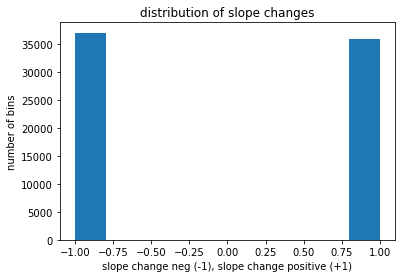

In [41]:
plt.hist(st)
plt.xlabel("slope change neg (-1), slope change positive (+1)")
plt.ylabel("number of bins")
plt.title("distribution of slope changes")
print("more bins transitions have negative slope ")